In [1]:
from keras.layers import Flatten, Conv2D, Conv2DTranspose, Dense, Input, Reshape, concatenate, Activation
from keras import Sequential
from keras.models import Model

import tensorflow as tf
import sys; sys.path.insert(0, '..')
import utils

import random
random.seed(1)

class FourSplit(Model):
    def __init__(self, n_enc, latent_dim, io_shape):
        super(FourSplit, self).__init__()
        n_filters = [32, 64]
#         n_enc_1d = n_enc**(1/2)
#         enc_input_shape = (n_enc, int(io_shape[0]//n_enc_1d), int(io_shape[1]//n_enc_1d), io_shape[2])
#         self.encoder = self._create_encoder(latent_dim//n_enc, enc_input_shape[1:], n_filters)
        self.encoder = self._create_encoder(latent_dim, io_shape, n_filters)
#         self.input_reshaper = utils.Reshaper(enc_input_shape, enc_input_shape[1:])
#         self.latent_reshaper = utils.Reshaper([latent_dim//n_enc], [latent_dim])

#         self.decoder = self._create_decoder(latent_dim, io_shape, n_filters)
        self.classifier = self._create_classifier(latent_dim)
        self.compile()

    def encode(self, x):
#         return self.encoder( self.input_reshaper(x) )
        return self.encoder( x )
    
    def decode(self, z):
#         return self.decoder( self.latent_reshaper(z) )
        return self.decoder( z )
    
    def classify(self, z):
#         return self.classifier( self.latent_reshaper(z))
        return self.classifier( z )
        
    def _create_encoder(self, latent_dim, input_shape, n_filters):
        return Sequential([
            Input(shape=input_shape),
            Conv2D(filters=n_filters[0], kernel_size=(3,3), strides=(2,2), activation='relu', padding='same'),
            Conv2D(filters=n_filters[1], kernel_size=(3,3), strides=(2,2), activation='relu', padding='same'),
#             Conv2D(filters=1, kernel_size=(1,1), strides=(1,1), activation='relu', padding='valid'),
            Flatten(),
            Dense(latent_dim)
        ], name='encoder')

    def _create_decoder(self, latent_dim, io_shape, n_filters):
        return Sequential([
            Input(shape=(latent_dim)),
            Dense(io_shape[0]//4 * io_shape[2]//4 * n_filters[0]),  # factor 4 due to conv.
            Reshape((io_shape[0]//4, io_shape[1]//4, n_filters[0])),
            Conv2DTranspose(filters=n_filters[1], kernel_size=(3,3), strides=(2,2), activation='relu', padding='same'),
            Conv2DTranspose(filters=n_filters[0], kernel_size=(3,3), strides=(2,2), activation='relu', padding='same'),
#             Conv2DTranspose(filters=1, kernel_size=(3,3), padding='same'),
            Activation('sigmoid', name='decoder_out')
        ])
    
    def _create_classifier(self, latent_dim):
        return Sequential([
            Input(shape=(latent_dim)),
            Dense(10, activation='softmax')
        ])
    
    def reco_loss(self, x_in, x_truth):
        z = self.encode(x_in)
        x_pred = self.decode(z)
        err = tf.reduce_mean(tf.square(tf.subtract(x_pred, x_truth)))
        return err
    
#     def class_loss(self, x_in, y_truth):
#         z = self.encode(x_in)
#         y_pred = self.classify(z)
#         err = categorical_crossentropy(y_truth, y_pred)
# #         acc = tf.metrics.accuracy(labels=tf.argmax(y_truth,1), predictions=tf.argmax(y_pred,1))
#         return err

In [2]:
import tensorflow as tf

@tf.function
def train_step(model, x_in, y_truth, optimizer):
    with tf.GradientTape() as tape:   # tf.Variables inside are tracked
        loss = model.class_loss(x_in, y_truth)
    grads = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(grads, model.trainable_variables))
    return loss

In [3]:
import time
from keras.optimizers import Adam
from keras.metrics import Mean
import numpy as np

optimizer = Adam(1e-4)
BATCH_SIZE = 32

LATENT_DIM = 16
N_ENC = 4
IO_SHAPE = (28,28,1)

train_data, test_data = utils.gen_data(N_ENC, BATCH_SIZE)
model = FourSplit(N_ENC, LATENT_DIM, IO_SHAPE)
model.encoder.load_weights('../weights/14_4split_encoder.h5')
for layer in model.encoder.layers:
    layer.trainable = False
# print(model.encoder.summary())

train_losses, test_losses = [], []
for epoch in range(1, 31):
# for epoch in range(1, 10):
    start_time = time.time()
    
    # Train
    train_loss = Mean()
    for i, (x_in, x_truth, y_truth) in enumerate(train_data):
        train_loss(train_step(model, x_in, y_truth, optimizer))
    train_losses.append(train_loss.result())
     
    # Test
    test_loss = Mean()
    for i, (x_in, x_truth, y_truth) in enumerate(test_data):
        test_loss(model.class_loss(x_in, y_truth))
    test_losses.append(test_loss.result())
    
    end_time = time.time()
    delta = round(end_time - start_time, 1)
    print("Epoch {:2d} || train loss: {:.5f} | test loss: {:.5f} | time: {}s".format(epoch, train_losses[epoch-1], test_losses[epoch-1], delta))

Epoch  1 || train loss: 7.95186 | test loss: 4.96002 | time: 5.2s
Epoch  2 || train loss: 3.52827 | test loss: 2.54260 | time: 3.9s
Epoch  3 || train loss: 2.04883 | test loss: 1.64419 | time: 3.9s
Epoch  4 || train loss: 1.49470 | test loss: 1.29766 | time: 3.9s
Epoch  5 || train loss: 1.25460 | test loss: 1.12862 | time: 4.0s
Epoch  6 || train loss: 1.12322 | test loss: 1.02852 | time: 4.1s
Epoch  7 || train loss: 1.03937 | test loss: 0.96195 | time: 3.9s
Epoch  8 || train loss: 0.98039 | test loss: 0.91431 | time: 3.9s
Epoch  9 || train loss: 0.93654 | test loss: 0.87839 | time: 3.8s
Epoch 10 || train loss: 0.90266 | test loss: 0.85030 | time: 3.9s
Epoch 11 || train loss: 0.87578 | test loss: 0.82814 | time: 3.9s
Epoch 12 || train loss: 0.85420 | test loss: 0.81027 | time: 3.9s
Epoch 13 || train loss: 0.83675 | test loss: 0.79597 | time: 3.9s
Epoch 14 || train loss: 0.82225 | test loss: 0.78408 | time: 3.9s
Epoch 15 || train loss: 0.81028 | test loss: 0.77429 | time: 3.8s
Epoch 16 |

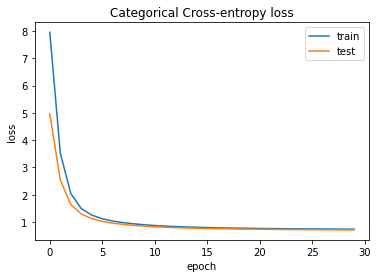

In [4]:
import matplotlib.pyplot as plt

plt.plot(train_losses)
plt.plot(test_losses)
plt.title('Categorical Cross-entropy loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right')
plt.show()

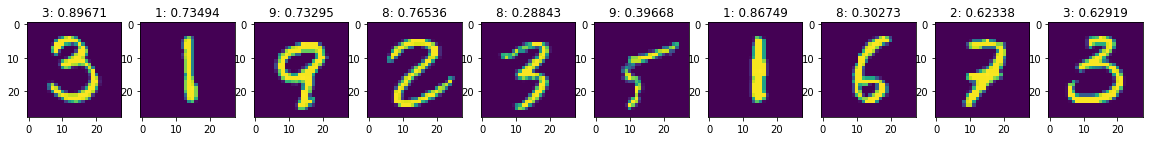

In [6]:
import matplotlib.pyplot as plt

n_samples = 10
plt.figure(figsize=(20,4))

for i, (x_in, x_truth, _) in enumerate(test_data.take(1)):
    y_pred = model.classify(model.encode(x_in))

    for j in range(n_samples):
        ax = plt.subplot(1, n_samples, j+1)
        ax.set_title("%d: %.5f" % (np.argmax(y_pred[j]), max(y_pred[j])))
        plt.imshow(tf.reshape(x_truth[j], (28, 28)))

# The classification results look much worse than the ones for the single CAE.

Construct CAE with new this architecture, save weights, train classifier and compare to above

In [2]:
import time
from keras.optimizers import Adam
from keras.metrics import Mean
import numpy as np

import tensorflow as tf

@tf.function
def train_step(model, x_in, x_truth, optimizer):
    with tf.GradientTape() as tape:   # tf.Variables inside are tracked
        loss = model.reco_loss(x_in, x_truth)
    grads = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(grads, model.trainable_variables))
    return loss

optimizer = Adam(1e-4)
BATCH_SIZE = 32

LATENT_DIM = 16
N_ENC = 1
IO_SHAPE = (28,28,1)

train_data, test_data = utils.gen_data(N_ENC, BATCH_SIZE)
model = FourSplit(N_ENC, LATENT_DIM, IO_SHAPE)
# model.encoder.load_weights('../weights/14_4split_encoder.h5')
# for layer in model.encoder.layers:
#     layer.trainable = False
# print(model.encoder.summary())

train_losses, test_losses = [], []
for epoch in range(1, 31):
    start_time = time.time()
    
    # Train
    train_loss = Mean()
    for i, (x_in, x_truth, y_truth) in enumerate(train_data):
        train_loss(train_step(model, x_in, x_truth, optimizer))
    train_losses.append(train_loss.result())
     
    # Test
    test_loss = Mean()
    for i, (x_in, x_truth, y_truth) in enumerate(test_data):
        test_loss(model.reco_loss(x_in, x_truth))
    test_losses.append(test_loss.result())
    
    end_time = time.time()
    delta = round(end_time - start_time, 1)
    print("Epoch {:2d} || train loss: {:.5f} | test loss: {:.5f} | time: {}s".format(epoch, train_losses[epoch-1], test_losses[epoch-1], delta))

(None, 16) (None, 1, 28, 28, 1)
(None, 16) (None, 28, 28, 1)
Epoch  1 || train loss: 0.04608 | test loss: 0.02236 | time: 11.1s
Epoch  2 || train loss: 0.02020 | test loss: 0.01811 | time: 9.3s
Epoch  3 || train loss: 0.01725 | test loss: 0.01601 | time: 9.3s
Epoch  4 || train loss: 0.01563 | test loss: 0.01481 | time: 9.4s
Epoch  5 || train loss: 0.01462 | test loss: 0.01405 | time: 9.4s
Epoch  6 || train loss: 0.01392 | test loss: 0.01347 | time: 9.4s
Epoch  7 || train loss: 0.01342 | test loss: 0.01299 | time: 9.2s
Epoch  8 || train loss: 0.01302 | test loss: 0.01266 | time: 9.2s
Epoch  9 || train loss: 0.01270 | test loss: 0.01237 | time: 9.3s
Epoch 10 || train loss: 0.01243 | test loss: 0.01223 | time: 9.3s
Epoch 11 || train loss: 0.01221 | test loss: 0.01196 | time: 9.4s
Epoch 12 || train loss: 0.01200 | test loss: 0.01180 | time: 9.4s
Epoch 13 || train loss: 0.01183 | test loss: 0.01164 | time: 9.4s
Epoch 14 || train loss: 0.01167 | test loss: 0.01150 | time: 9.4s
Epoch 15 || tr

In [ ]:
model.encoder.save_weights('../weights/14_1split_encoder.h5')
model.decoder.save_weights('../weights/14_1split_decoder.h5')

import matplotlib.pyplot as plt

# summarize history for loss
plt.plot(train_losses)
plt.plot(test_losses)
plt.title('MSE loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right')
plt.show()

# Train CAE on classifier and compare to 4-split with classifier.

In [3]:
import time
from keras.optimizers import Adam
from keras.metrics import Mean
import numpy as np
from keras.losses import CategoricalCrossentropy

import tensorflow as tf

loss_fn = CategoricalCrossentropy(from_logits=False)

@tf.function
def train_step(model, x_in, y_truth, optimizer):
    with tf.GradientTape() as tape:   # tf.Variables inside are tracked
#         loss = model.class_loss(x_in, y_truth)
        z = model.encoder(x_in, training=False)
        y_pred = model.classifier(z, training=True)
        loss = loss_fn(y_truth, y_pred)
    grads = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(grads, model.trainable_variables))
    return loss

# optimizer = Adam(1e-4)
optimizer = Adam()
# BATCH_SIZE = 32
BATCH_SIZE = 64


LATENT_DIM = 16
N_ENC = 1
IO_SHAPE = (28,28,1)

train_data, test_data = utils.gen_data(N_ENC, BATCH_SIZE)
model = FourSplit(N_ENC, LATENT_DIM, IO_SHAPE)
# model.encoder.load_weights('../weights/14_1split_encoder.h5')
model.encoder.load_weights('../weights/CE16_epoch25_weights.h5')
for layer in model.encoder.layers:
    layer.trainable = False
# print(model.encoder.summary())

train_losses, test_losses = [], []
# for epoch in range(1, 31):
for epoch in range(1, 11):
    start_time = time.time()
    
    # Train
    train_loss = Mean()
    for i, (x_in, x_truth, y_truth) in enumerate(train_data):
        train_loss(train_step(model, x_truth, y_truth, optimizer))
    train_losses.append(train_loss.result())
     
    # Test
#     test_loss = Mean()
#     for i, (x_in, x_truth, y_truth) in enumerate(test_data):
#         test_loss(model.class_loss(x_truth, y_truth))
#     test_losses.append(test_loss.result())
    
    end_time = time.time()
    delta = round(end_time - start_time, 1)
#     print("Epoch {:2d} || train loss: {:.5f} | test loss: {:.5f} | time: {}s".format(epoch, train_losses[epoch-1], test_losses[epoch-1], delta))
    print("Epoch {:2d} || train loss: {:.5f} | time: {}s".format(epoch, train_losses[epoch-1], delta))

Epoch  1 || train loss: 1.39399 | time: 3.3s
Epoch  2 || train loss: 0.53913 | time: 1.9s
Epoch  3 || train loss: 0.37714 | time: 1.9s
Epoch  4 || train loss: 0.31158 | time: 1.9s
Epoch  5 || train loss: 0.27758 | time: 1.9s
Epoch  6 || train loss: 0.25783 | time: 1.9s
Epoch  7 || train loss: 0.24587 | time: 1.9s
Epoch  8 || train loss: 0.23840 | time: 1.9s
Epoch  9 || train loss: 0.23337 | time: 2.0s
Epoch 10 || train loss: 0.22996 | time: 1.9s


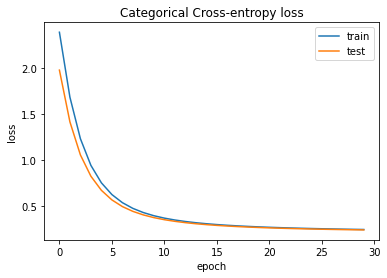

In [3]:
import matplotlib.pyplot as plt

plt.plot(train_losses)
plt.plot(test_losses)
plt.title('Categorical Cross-entropy loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right')
plt.show()

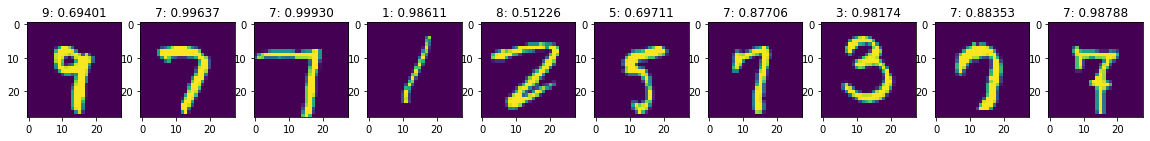

In [4]:
import matplotlib.pyplot as plt

n_samples = 10
plt.figure(figsize=(20,4))

for i, (x_in, x_truth, _) in enumerate(test_data.take(1)):
    y_pred = model.classify(model.encode(x_in))

    for j in range(n_samples):
        ax = plt.subplot(1, n_samples, j+1)
        ax.set_title("%d: %.5f" % (np.argmax(y_pred[j]), max(y_pred[j])))
        plt.imshow(tf.reshape(x_truth[j], (28, 28)))

In [7]:
print(model.encoder.summary())
print(model.classifier.summary())

Model: "encoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 14, 14, 32)        320       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 7, 7, 64)          18496     
_________________________________________________________________
flatten (Flatten)            (None, 3136)              0         
_________________________________________________________________
dense (Dense)                (None, 16)                50192     
Total params: 69,008
Trainable params: 0
Non-trainable params: 69,008
_________________________________________________________________
None
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_2 (Dense)              (None, 10)                170       
Total params: 170
Trainable 